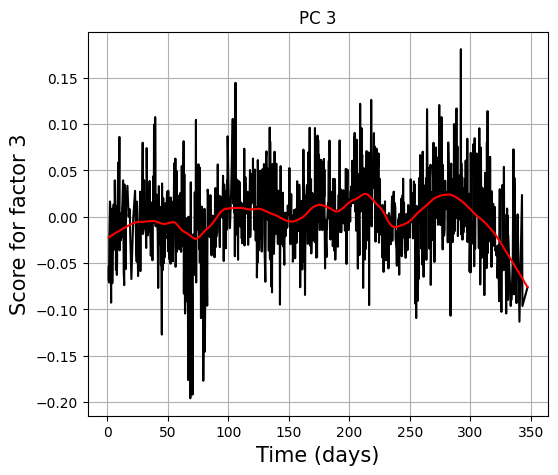

In [1]:
import numpy as np
from read import *
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import scipy.stats as stats
from statsmodels.nonparametric.smoothers_lowess import lowess

pdf = PdfPages("autocor_py.pdf")

df = get_goes(2017)

# Block size.  If bs=8000 the overall time of each block
# is around 4.4 hours.
bs = 8000

# Standard error of Kendall's tau for iid data.
tse = np.sqrt(2 * (2 * bs + 5) / (9 * bs * (bs - 1)))

# Make blocks of 'bs' consecutive time points with
# approximately 2-second spacing.
tix, flx = make_blocks(df, bs, 0)

n, p = flx.shape

# Consider autocorrelation at these time lags
dlags = np.arange(1, 200, 10)

# Convert lags to time in minutes
dtime = dlags * 2 / 60

# Calculate these quantiles across blocks of the autocorrelations.
pr = [0.25, 0.5, 0.75]

# Get the autocorrelation for each block
qd = np.zeros((n, len(dlags)))
for (j,d) in enumerate(dlags):
    for i in range(flx.shape[0]):
        qd[i, j] = stats.kendalltau(flx[i, 0:p-d], flx[i, d:]).correlation

# Spaghetti plot of a random subset of the block-wise autocorrelation functions.
plt.clf()
plt.axes([0.1, 0.1, 0.75, 0.8])
plt.grid(True)
ii = np.random.choice(qd.shape[0], 200, replace=False)
for i in range(qd.shape[0]):
    plt.plot(dtime, qd[i, :], "-", color="grey", alpha=0.5)
plt.xlabel("Time lag (minutes)", size=15)
plt.ylabel("Tau autocorrelation", size=15)
pdf.savefig()

# Plot some quantiles of the autocorrelation functions.
plt.clf()
plt.axes([0.1, 0.1, 0.72, 0.8])
plt.grid(True)
for i, p in enumerate(pr):
    qq = np.quantile(qd, p, axis=0)
    plt.plot(dtime, qq, label="%.2f" % p)
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, loc="center right")
leg.draw_frame(False)
plt.xlabel("Time lag (minutes)", size=15)
plt.ylabel("Tau autocorrelation quantile", size=15)
pdf.savefig()

# PC decompose the estimated autcorrelation functions
qdm = qd.mean(0)
qdc = qd - qdm
u, s, vt = np.linalg.svd(qdc, 0)
v = vt.T
scores = np.dot(u, np.diag(s))

# Plot the mean autocorrelation +/- each PC.
for j in range(3):
    plt.clf()
    plt.axes([0.1, 0.1, 0.72, 0.8])
    plt.grid(True)
    plt.title("PC %d" % (j + 1))
    sd = scores[:, j].std(0)
    plt.plot(dtime, qdm, '-', color="black")
    plt.plot(dtime, qdm + sd*v[:, j], '-', color="red")
    plt.plot(dtime, qdm - sd*v[:, j], '-', color="blue")
    plt.xlabel("Time lag (minutes)", size=15)
    plt.ylabel("Tau autocorrelation quantile", size=15)
    pdf.savefig()

# Plot the scores for each factor
for j in range(3):
    yh = lowess(scores[:, j], tix[:, 0], frac=0.1)
    plt.clf()
    plt.axes([0.15, 0.1, 0.72, 0.8])
    plt.grid(True)
    plt.title("PC %d" % (j + 1))
    td = tix[:, 0] / (24 * 60 * 60)
    plt.plot(td, scores[:, j], '-', color="black")
    plt.plot(td, yh[:, 1], '-', color="red")
    plt.xlabel("Time (days)", size=15)
    plt.ylabel("Score for factor %d" % (j + 1), size=15)
    pdf.savefig()

pdf.close()